In [1]:

import numpy as np 
import matplotlib.pylab as plt
import os
from scipy.stats import norm
from scipy.stats import beta
from scipy import integrate
import time

In [ ]:
def log_plus(x,y):
    
    if x > y:
      summ = x + np.log(1+np.exp(y-x))
    else:
        summ = y + np.log(1+np.exp(x-y))
    return summ

def log_sum(vec): 
    r = -np.Inf
    for i in range(len(vec)):
       #print('element:',vec[i])
       r =log_plus(r, vec[i])
       #print(r)
    return r



class Gaussian_model(object): # the Gaussian model
    
    def __init__(self, ndim=2,v=0.01):
        self.a = np.ones(ndim)*1
        self.b = np.ones(ndim)*1
    def lnlikefn(self, x):
        
        return np.sum(-(x**2)/(2*v),axis=0) #axis zeros two sum all likelihood of n parameters

    def lnpriorfn(self, x):
        
        return  np.sum(norm.logpdf(x , loc = 0 , scale = 1 ))
    
def direct_samp_ln(N_chain,dim,v,n_samples): # Direct sampling of the power log-likelihood
    
    x = np.linspace(1e-8,1,N_chain)
    #beta_x = x
    beta_x = beta.ppf(x,0.3,1)

    bet = beta_x[::-1]
    #bet = beta_x

    #print('bet :',bet)
    temp = 1/beta_x[::-1]
    #print('temp:',temp)
    ln_like = {}
    
    glo = Gaussian_model(ndim=dim,v=v)
    
    for i in range(len(bet)):
        #print('bet :',bet[i])
        #print('temp:', temp[i])
        #p_b = np.random.lognormal(0,v/(v+bet[i]),size = n_samples)  
        p_b = np.random.normal(0,np.sqrt(v/(v+bet[i])),size = (dim,n_samples))
        
        ln_b = glo.lnlikefn(x= p_b)
        #print('p_b:',p_b)
        #print('len:', len(ln_b))
        ln_like[str(temp[i])] = ln_b
        
    return ln_like

def direct_samp_post(dim,v,n_samples): # direct posterior sampling
    
    #print('Direct sampling from post :',n_samples)
    ln_post = {}
    for i in range(dim):

        p_b = norm.rvs(loc=0, scale=np.sqrt(v/(v+1)), size=n_samples)
        ln_post[str(i+1)] = p_b
        
    return ln_post

def SS(ln_like): # Stepinstone Sampling

    #print('Estimating the log marginal likelihood using SS ')
    log_z =0
    temp_list = list(ln_like.keys())
    #print('temperature list is:',temp_list)
    temp = np.array([float(kk) for kk in temp_list])
    temp_list = temp_list[::-1]
    temp_rev = temp[::-1]
    beta = 1/temp_rev
    #print('temp_list',temp_list)
    #print('beta',beta)
    log_save_like = np.zeros(len(beta)-1)
    
    for i in range(len(beta)-1):
        
        #print(beta[i+1])
        diff = beta[i+1] - beta[i]
        #print('diff',diff)
        chain = ln_like.get(temp_list[i])
        #print('chains:', chain)
        #chain = np.exp(chain)
        n = len(chain)
        #print('n:',n)
        log_save_like[i] = log_sum(chain*diff)  #for loop

    log_z = np.sum(log_save_like) - (len(beta)-1)*np.log(n)
    #log_z = np.mean()
    return log_z   

def TI(ln_like): #Thermodynamic Integration
    
    #print('Estimating the log marginal likelihood using TI ')
    log_z =0
    temp_list = list(ln_like.keys())
    #print('temperature list is:',temp_list)
    temp = np.array([float(kk) for kk in temp_list])
    temp_list = temp_list[::-1]
    temp_rev = temp[::-1]
    beta = 1/temp_rev
    #print('temp_list',temp_list)
    
    exp_like = np.zeros(len(beta))
    for i in range(len(beta)):
        exp_like[i] = np.mean(ln_like.get(temp_list[i]))
        
    #log_z = integrate.simpson(y = exp_like,x = beta,even='avg')
    log_z = integrate.trapezoid(y=exp_like, x=beta)

    return log_z
    
    

In [ ]:
## GSS direct sampling

def  direct_import(ndim,v,nchain,nsamp,ncal):

    N_chain = nchain
    pse_rk = np.zeros(N_chain)
    beta_dis=0.3
    #print("Running GSS importance sampling with ndim:",ndim)
    def lnpriorfn( x):
        
        return  np.sum(norm.logpdf(x , loc = 0 , scale = 1 ))
    
    def lnlikefn(x,v):
         return np.sum(-(x**2)/(2*v))
    
    def lnpriorref(x,mu0s,sig0s):
            return  np.sum(norm.logpdf(x , loc = mu0s , scale = sig0s ))
            #return  np.sum(norm.logpdf(x , loc = 0 , scale = 1 ))    
            
    def new_lnlikefn (x,v,mu0s,sig0s):
        return (lnlikefn(x,v)+lnpriorfn(x)) - lnpriorref(x,mu0s,sig0s)
    
    
        

        
    def ref_calibrate(post_samples):
        
        li = list(post_samples.keys())

        mu = np.zeros(len(li))
        sig = np.zeros(len(li))
        for j in range(len(li)):
                                   # number of samples to get from each parameter
              ran_samples = post_samples.get(li[j])
              mu[j] = np.mean(ran_samples)
              #mu[j] = np.median(ran_samples)
              sig[j] = np.std(ran_samples)
        #print('reference prior defined with sig',sig)
        #print('reference prior defined with mu0')
        return mu , sig    
        
    dT = np.linspace(1e-8,1,N_chain)
    
    beta_dT = beta.ppf(dT,beta_dis,1)
    #print('beta dt :',beta_dT)
    
    bet = beta_dT
    
    q = np.zeros((len(beta_dT),nsamp))
    post = direct_samp_post( ndim, v, ncal)

    def mu_cal(bet,Xi,Si):
        mu = (Xi *(1-bet)/Si**2)/((bet*(1+v)/v)+((1-bet)/Si**2))
        var = ((bet*(1+v)/v)+((1-bet)/Si**2))**-1
        return mu , var
    
    Xi , Si = ref_calibrate(post)
    #print(Xi)

    for i in range(N_chain):
        mu , sig2 = mu_cal(beta_dT[i],Xi,Si)
        #print(len(mu),len(sig2))
        for j in range(nsamp):  
            tita = np.random.normal(mu,np.sqrt(sig2),size=(ndim))
            q[i,j] = new_lnlikefn(tita,v,Xi , Si)
        #print( bet[i], q[i,:] )
    #plt.hist(q[idx,:])
    #plt.title(idx)
    
    #print(bet)
    nu_k = np.zeros(N_chain)
    for i in range(N_chain-1):
            targ_dist_b = q[i,:]
            nu_k[i+1] = np.max(targ_dist_b)
        
    #nu_k = np.zeros(N_chain)
    #print('nu_k:', nu_k)

    for i in range(1,len(beta_dT)):
            

            targ_dist_b = q[i-1,:]
            
            #n_samp = len(targ_dist_b)
            #print('nu_k k:', nu_k[i])
            #print('len(target k-1):',len(targ_dist_b))
            diff = bet[i] - bet[i-1]
            
            #print("beta diff :", diff)
            
            stab = targ_dist_b - nu_k[i]
            
            pse_rk[i] = diff*nu_k[i] + log_sum(diff*stab) -  np.log(nsamp) ## for loop log sum
            

    log_r_k = np.sum(pse_rk)  
    #print('pse_rk', pse_rk)
    #print('log(n)',(len(beta_dT)-1)*np.log(n_samp)) 
    return log_r_k 


In [ ]:
## Beta chains direct simpling for SS and TI

start_time = time.time()


N = 100

temp = [4,8,16,32,64]



z_SS_arr = np.zeros((N,len(temp)))
z_TI_arr = np.zeros((N,len(temp)))
ndim = 50
v = 0.01


for k in range(len(temp)):
   for i in range(N):
    ln_test = direct_samp_ln(temp[k], ndim, v, 1000 )
    z_SS_arr[i,k] = SS(ln_test)
    z_TI_arr[i,k] = TI(ln_test)

stop_time = time.time()

print ("Time for SS estimation ---", int((time.time()-start_time)), " seconds .---")

Time for SS estimation --- 9  seconds .---


<Figure size 640x480 with 0 Axes>

In [19]:
## GSS for figure 1 
ndim = 50
v = 0.01
nchain = [4,8,16,32,64]

ncal = 1000

N = 100
z_GSS_arr= np.zeros((N,len(nchain)))


for k in range(len(nchain)):
    for i in range(N):
         z_GSS_arr[i,k] = direct_import(ndim,v,nchain[k],10,ncal)


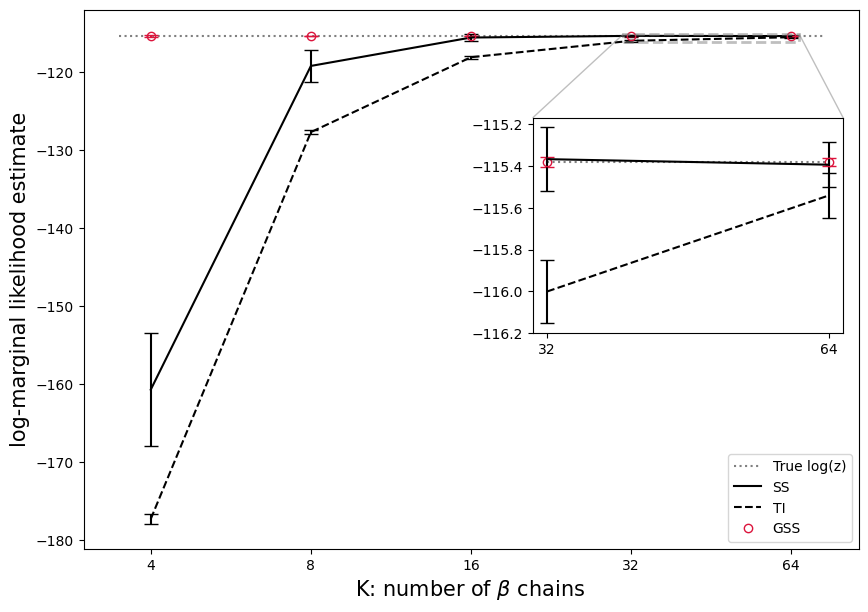

In [21]:
## Figure 1
x1 = [1,2,3,4,5]
#x1 =temp
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
plt.hlines(y=np.log((v/(v+1)))*(ndim/2),colors='grey',linestyle='dotted',xmin=0.8, xmax=5.2,label='True log(z)')



# Calculate means
mean_TI = np.mean(z_TI_arr, axis=0)
mean_SS = np.mean(z_SS_arr, axis=0)
mean_GSS = np.mean(z_GSS_arr, axis=0)


error_TI = np.std(z_TI_arr, axis=0)
error_SS = np.std(z_SS_arr, axis=0)
error_GSS = np.std(z_GSS_arr, axis=0)


gss_color = 'crimson'
data2_color = 'black'

ax.errorbar(x1, mean_SS, yerr=error_SS, fmt='-', color='black', capsize=5)
ax.errorbar(x1, mean_TI, yerr=error_TI, fmt='--', color='black', capsize=5, markerfacecolor='none')
ax.errorbar(x1, mean_GSS, yerr=error_GSS, fmt='o', color=gss_color, capsize=5, markerfacecolor='none')

ax.plot([], [], '-', color='black', label='SS')
ax.plot([], [],'--', color='black', label='TI', markerfacecolor='none')
ax.plot([], [],'o', color=gss_color, label='GSS', markerfacecolor='none')
ax.set_xticks(x1,labels=['4', '8', '16', '32','64'],fontsize=10)
ax.legend()


zm = ax.inset_axes([0.58,0.40,0.4,0.4])
i=3
j=5
zm.errorbar(x1[i:j], mean_GSS[i:j], yerr=error_GSS[i:j], fmt='o', color=gss_color, capsize=5, markerfacecolor='none')

zm.hlines(y=np.log((v/(v+1)))*(ndim/2),colors='grey',linestyle='dotted',xmin=4, xmax=5,label='True log(z)')
zm.errorbar(x1[i:j], mean_SS[i:j], yerr=error_SS[i:j], fmt='-', color='black', capsize=5)
zm.errorbar(x1[i:j], mean_TI[i:j], yerr=error_SS[i:j], fmt='--', color='black', capsize=5)
zm.set_xticks(x1[i:j],labels=['32','64'])

ax.indicate_inset_zoom(zm,edgecolor='grey',lw=2,ls='dashed')


plt.ylabel('log-marginal likelihood estimate', fontsize=15)
plt.xlabel(r'K: number of $\beta$ chains ', fontsize=15)
plt.legend()

plt.savefig("ss gss ti 50 dim.pdf", format="pdf", dpi=200,bbox_inches="tight")
plt.show()

In [23]:
## Direct sampling for GSS comparison

ndim = 2000
v = 0.01
nchain = [4,8,16,32,64]
nsamp = [1,10,50,100,500]
ncal = 1000

N = 100
direct_GSS= np.zeros((N,len(nchain)))
direct_GSS_nsamp= np.zeros((N,len(nchain)))

for k in range(len(nchain)):
    for i in range(N):
         direct_GSS[i,k] = direct_import(ndim,v,nchain[k],10,ncal)

for k in range(len(nsamp)):
    for i in range(N):
         direct_GSS_nsamp[i,k] = direct_import(ndim,v,4,nsamp[k],ncal)
        


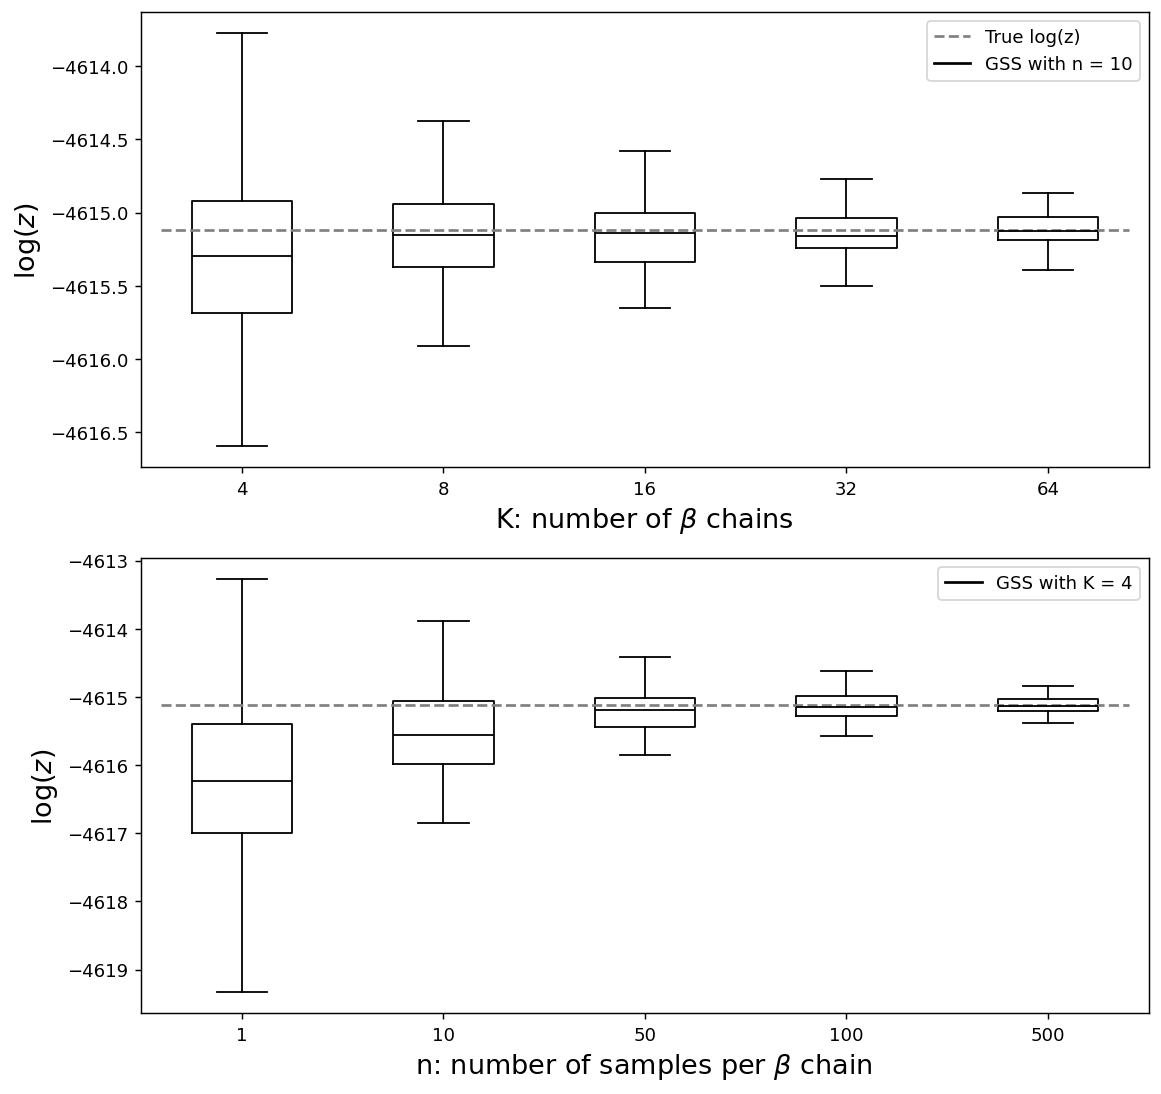

true log(z): -4615.12051684126


In [ ]:
## Figure 2 GSS comparison
x1 = [1,2,3,4,5]
lab1 = ['4','8', '16', '32','64']
lab2 = ['1','10', '50', '100','500']


data3 = direct_GSS
data4 = direct_GSS_nsamp
true_z = np.log((v/(v+1)))*(ndim/2)

fig, ( ax1, ax2) =  plt.subplots(nrows=2,figsize=(10, 10),dpi=130)

data_color = 'black'
data2_color = 'black'
outli = False

ax1.boxplot(data3 , boxprops=dict(color=data2_color, alpha=1),
            whiskerprops=dict(color=data2_color, alpha=1),
            capprops=dict(color=data2_color, alpha=1),
            medianprops=dict(color=data2_color),
            showfliers=outli)


ax1.hlines(y=true_z,colors='grey',linestyle='dashed', xmin=min(x1)-0.4, xmax=max(x1)+0.4,label='True log(z)')

ax1.plot([],[], color=data2_color,label='GSS with n = 10')

ax2.boxplot(data4 , boxprops=dict(color=data2_color, alpha=1),
            whiskerprops=dict(color=data2_color, alpha=1),
            capprops=dict(color=data2_color, alpha=1),
            medianprops=dict(color=data2_color),
            showfliers=outli)

ax2.hlines(y=true_z,colors='grey',linestyle='dashed', xmin=min(x1)-0.4, xmax=max(x1)+0.4)
ax2.plot([],[], color=data2_color,label='GSS with K = 4')

ax1.legend()



ax1.set_xticks(x1,labels= lab1)
ax2.set_xticks(x1,labels= lab2)

ax1.set_ylabel(r'$\log(z)$', fontsize=15)

ax1.set_xlabel(r'K: number of $\beta$ chains ', fontsize=15)

ax2.set_ylabel(r'$\log(z)$', fontsize=15)


ax2.set_xlabel(r'n: number of samples per $\beta$ chain ', fontsize=15)

ax2.legend()



plt.show()
print('true log(z):', true_z)
mean_GSS = np.mean(direct_GSS, axis=0)
error_GSS = np.std(direct_GSS, axis=0)
